# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from environments import Snake
from methods import QNetwork, ReplayMemory

# Snake class

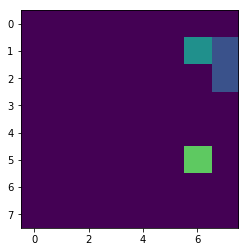

In [3]:
s = Snake()
img = s.reset()
s.plot_state()

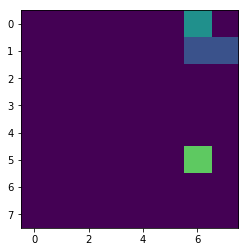

In [4]:
img, r, done = s.step(2)
s.plot_state()

# NN training

In [5]:
class SnakeAgent:
    
    def __init__(self, model_name="baseline_agent"):
        
        """Class for training and evaluating DQN agent on Atari games
        
        Parameters
        ----------
        game_id: str
            game identifier in gym environment, e.g. "Pong"
        num_actions: int
            number of actions the agent can take
        model_name: str
            name of the model
        """
        
        ############################ Game environment ############################
        
        self.train_env = Snake(grid_size=(4, 4))
        self.num_actions = 3
            
        self.path = "snake_models" + "/" + model_name
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        
        ############################# Agent & Target #############################
        
        tf.reset_default_graph()
        self.agent_net = QNetwork(self.num_actions, state_shape=[4, 4, 1], 
                                  convs=[[16, 2, 1], [32, 1, 1]], scope="agent")
        self.target_net = QNetwork(self.num_actions, state_shape=[4, 4, 1],
                                   convs=[[16, 2, 1], [32, 1, 1]], scope="target")
        
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        all_vars = tf.trainable_variables()
        num_vars = len(all_vars) // 2
        self.agent_vars = all_vars[:num_vars]
        self.target_vars = all_vars[num_vars:]
        
    def set_parameters(self, 
                       replay_memory_size=50000,
                       replay_start_size=10000,
                       init_eps=1,
                       final_eps=0.02,
                       annealing_steps=100000,
                       discount_factor=0.99,
                       max_episode_length=2000):
        
        # create experience replay and fill it with random policy samples
        self.rep_buffer = ReplayMemory(replay_memory_size)
        frame_count = 0
        while (frame_count < replay_start_size):
            s = self.train_env.reset()
            for time_step in range(max_episode_length):
                a = np.random.randint(self.num_actions)
                s_, r, end = self.train_env.step(a)
                self.rep_buffer.push(s, a, np.sign(r), s_, end)
                s = s_
                frame_count += 1
                if end:
                    break
                        
        self.eps = init_eps
        self.final_eps = final_eps
        self.eps_drop = (init_eps - final_eps) / annealing_steps
        self.gamma = discount_factor
        self.max_ep_length = max_episode_length
        
    def train(self,
              gpu_id=0,
              batch_size=32,
              agent_update_freq=4,
              target_update_freq=5000,
              tau=1,
              max_num_episodes=100000,
              max_num_epochs=50000,
              performance_print_freq=500,
              save_freq=10000):
        
        target_ops = self.update_target_graph(tau)
        
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        
        
        with tf.Session(config=config) as sess:
            sess.run(self.init)
            
            train_rewards = []
            frame_counts = []
            frame_count = 0
            episode_count = 0
            num_epochs = 0
            
            while num_epochs < max_num_epochs:
                
                train_ep_reward = 0
                
                # reset the environment / start new game
                s = self.train_env.reset()
                for time_step in range(self.max_ep_length):
                    
                    # choose action e-greedily
                    if np.random.rand(1) < self.eps:
                        a = np.random.randint(self.num_actions)
                    else:
                        a = self.agent_net.get_q_argmax(sess, [s])
                        
                    # make step in the environment    
                    s_, r, end = self.train_env.step(a)
                    train_ep_reward += r
                    
                    # save transition into experience replay
                    self.rep_buffer.push(s, a, r, s_, end)
                    
                    # update current state and statistics
                    s = s_
                    frame_count += 1
                    
                    # reduce epsilon according to schedule
                    if self.eps > self.final_eps:
                        self.eps -= self.eps_drop
                    
                    # update network weights
                    if frame_count % agent_update_freq == 0:
                        
                        batch = self.rep_buffer.get_batch(batch_size)
                        
                        # estimate right hand side of the Bellman equation
                        max_actions = self.agent_net.get_q_argmax(sess, batch.s_)
                        q_values = self.target_net.get_q_values(sess, batch.s_)
                        double_q = q_values[np.arange(batch_size), max_actions]
                        targets = batch.r + (self.gamma * double_q * batch.end)
                        
                        # update agent network
                        self.agent_net.update(sess, batch.s, batch.a, targets)
                        
                        # update target network
                        if tau == 1:
                            if frame_count % target_update_freq == 0:
                                self.update_target_weights(sess, target_ops)
                        else: self.update_target_weights(sess, target_ops)
                    
                    # make checkpoints of network weights and save learning curve
                    if frame_count % save_freq == 1:
                        num_epochs += 1
                        try:
                            self.saver.save(sess, self.path+"/model", global_step=num_epochs)
                            np.savez(self.path+"/learning_curve.npz", r=train_rewards, f=frame_counts)
                        except:
                            pass
                    
                    # if game is over, reset the environment
                    if end: 
                        break
                         
                episode_count += 1
                train_rewards.append(train_ep_reward)
                frame_counts.append(frame_count)
                
                # print performance once in a while
                if episode_count % performance_print_freq == 0:
                    avg_reward = np.mean(train_rewards[-performance_print_freq:])
                    print("Train info:", frame_count, avg_reward, self.eps)  

    def update_target_graph(self, tau):
        op_holder = []
        for agnt, trgt in zip(self.agent_vars, self.target_vars):
            op = trgt.assign(agnt.value()*tau + (1 - tau)*trgt.value())
            op_holder.append(op)
        return op_holder

    def update_target_weights(self, sess, op_holder):
        for op in op_holder:
            sess.run(op)

In [6]:
aa = SnakeAgent(model_name="baseline_dqn3")

In [7]:
aa.set_parameters(max_episode_length=400, replay_memory_size=50000, replay_start_size=10000)

In [8]:
aa.train(gpu_id=1, batch_size=64)

Train info: 1991 -0.526 0.9804882000001021
Train info: 4253 -0.436 0.958320600000218
Train info: 6576 -0.482 0.9355552000003371
Train info: 9082 -0.464 0.9109964000004656
Train info: 11431 -0.49 0.887976200000586
Train info: 14089 -0.422 0.8619278000007222
Train info: 16606 -0.434 0.8372612000008512
Train info: 19253 -0.424 0.8113206000009869
Train info: 21996 -0.41 0.7844392000011275
Train info: 24924 -0.384 0.7557448000012776
Train info: 27997 -0.33 0.7256294000014352
Train info: 30877 -0.346 0.6974054000015828
Train info: 34098 -0.264 0.6658396000017479
Train info: 37197 -0.286 0.6354694000019068
Train info: 40553 -0.208 0.6025806000020788
Train info: 43901 -0.238 0.5697702000022504
Train info: 47308 -0.214 0.5363816000024251
Train info: 50818 -0.142 0.501983600002605
Train info: 54349 -0.208 0.4673798000026012
Train info: 57849 -0.15 0.43307980000258633
Train info: 61260 -0.094 0.39965200000257184
Train info: 64872 -0.088 0.3642544000025565
Train info: 68470 -0.026 0.32899400000254

Train info: 2198101 11.798 0.019990200002433314
Train info: 2219053 11.634 0.019990200002433314
Train info: 2240111 11.868 0.019990200002433314
Train info: 2260986 11.754 0.019990200002433314
Train info: 2281922 11.86 0.019990200002433314
Train info: 2303241 11.946 0.019990200002433314
Train info: 2324222 11.844 0.019990200002433314
Train info: 2345737 12.11 0.019990200002433314
Train info: 2367019 11.908 0.019990200002433314
Train info: 2387465 11.504 0.019990200002433314
Train info: 2408958 11.972 0.019990200002433314
Train info: 2430282 11.846 0.019990200002433314
Train info: 2451433 11.752 0.019990200002433314
Train info: 2472963 12.188 0.019990200002433314
Train info: 2494224 11.858 0.019990200002433314
Train info: 2515187 12.036 0.019990200002433314
Train info: 2536276 11.892 0.019990200002433314
Train info: 2556749 11.592 0.019990200002433314
Train info: 2577719 11.606 0.019990200002433314
Train info: 2598716 11.77 0.019990200002433314
Train info: 2619668 11.73 0.019990200002433

KeyboardInterrupt: 

# Visualization

In [ ]:
tf.reset_default_graph()
agent_net = QNetwork(4, scope="agent")
saver = tf.train.Saver()
env = Snake()

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = str(3)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


with tf.Session() as sess:
    saver.restore(sess, "snake_models/baseline_dqn2/model-2618")
    s = env.reset()
    for i in range(1000):
        a = agent_net.get_q_argmax(sess, [s])[0]
        s, r, done = env.step(a)
        
        
        env.plot_state()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        #time.sleep(0.01)
        
        if done: break

In [ ]:
curve = np.load('snake_models/baseline_dqn2/learning_curve.npz')

In [ ]:
vals = curve['r']

In [ ]:
plt.plot(vals)

In [ ]:
def plot_average(r, eta):
    ret = np.cumsum(r, dtype=np.float)
    ret[eta:] = ret[eta:] - ret[:-eta] 
    y = ret[eta - 1:] / eta
    return y

def plot_performance(path, eta=10):
    r_train = np.load(path + "/learning_curve.npz")["r"]
    y = plot_average(r_train, eta)
    plt.plot(y)
    plt.grid()

In [ ]:
plot_performance('snake_models/baseline_dqn2', eta=400)